In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [4]:
faults = pd.read_csv('../data/J1939Faults.csv')
faults['EventTimeStamp'] = pd.to_datetime(faults['EventTimeStamp'])
faults['LocationTimeStamp'] = pd.to_datetime(faults['LocationTimeStamp'])
diag = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv')

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
vehicle = pd.read_excel('../data/Vehicle_Make.xlsx')
fault_code = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [64]:
fault_code[fault_code['SPN']==5246] 

,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
2518,Y,3712,167,Not Mapped,Not Mapped,Not Mapped,0,5246,0,Not Mapped,Red,Stop / Shutdown,Aftertreatment SCR Operator Inducement - Data ...,SCR inducement of 5 mph derate - Fault Code 41...
2781,Y,4134,167,Not Mapped,Not Mapped,Not Mapped,0,5246,15,Not Mapped,Amber,Warning,Aftertreatment SCR Operator Inducement - Data ...,SCR inducement - Least Severe - Fault Code 371...
4338,Y,6254,167,Not Mapped,Not Mapped,Not Mapped,0,5246,16,Not Mapped,Amber,Warning,Aftertreatment SCR Operator Inducement Severit...,NaN


In [59]:
diag

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1
...,...,...,...,...
12821621,12864020,EngineCoolantTemperature,181.4,1248457
12821622,12864021,ParkingBrake,False,1248457
12821623,12864022,SwitchedBatteryVoltage,14.1,1248457
12821624,12864023,DistanceLtd,28606.65625,1248457


In [9]:
faults[faults['spn']==5246].nunique()

RecordID                 1195
ESS_Id                   1189
EventTimeStamp           1183
eventDescription            0
actionDescription           0
ecuSoftwareVersion        215
ecuSerialNumber           182
ecuModel                    7
ecuMake                     6
ecuSource                   2
spn                         1
fmi                         5
active                      2
activeTransitionCount      54
faultValue                  0
EquipmentID               224
MCTNumber                 210
Latitude                  852
Longitude                 855
LocationTimeStamp        1150
dtype: int64

In [44]:
faults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   ESS_Id                 1187335 non-null  int64         
 2   EventTimeStamp         1187335 non-null  datetime64[ns]
 3   eventDescription       1126490 non-null  object        
 4   actionDescription      0 non-null        float64       
 5   ecuSoftwareVersion     891285 non-null   object        
 6   ecuSerialNumber        844318 non-null   object        
 7   ecuModel               1122577 non-null  object        
 8   ecuMake                1122577 non-null  object        
 9   ecuSource              1187335 non-null  int64         
 10  spn                    1187335 non-null  int64         
 11  fmi                    1187335 non-null  int64         
 12  active                 11873

In [45]:
derate = faults[faults['spn']==5246]

In [46]:
derate

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
45,46,990931,2015-02-21 12:10:51,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,True,1,NaN,1395,105349612,36.065972,-86.433425,2015-02-21 12:11:27
1918,1919,1007751,2015-02-22 19:44:55,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,True,1,NaN,1395,105349612,36.066203,-86.434814,2015-02-22 19:46:27
2058,2059,1010486,2015-02-23 04:00:21,NaN,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,79464664,6X1u10D1500000000,CMMNS,0,5246,0,False,1,NaN,1395,105349612,36.066666,-86.434537,2015-02-23 01:06:06
2089,2090,1011009,2015-02-23 05:05:44,NaN,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,1630,105329900,40.733009,-74.087777,2015-02-23 05:08:23
2971,2972,1026305,2015-02-23 15:54:22,NaN,NaN,unknown,unknown,unknown,unknown,0,5246,0,True,1,NaN,1487,105369355,28.077361,-81.897083,2015-02-23 15:54:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183032,1244156,121610128,2020-02-19 07:02:33,NaN,NaN,05317106*05005224*051718172255*09401583*G1*BDR*,79845785,6X1u13D1500000000,CMMNS,0,5246,0,True,1,NaN,1814,105369518,36.067037,-86.434120,2020-02-19 07:03:09
1183684,1244808,121909497,2020-02-21 07:23:44,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,16,True,1,NaN,2211,105329862,36.066296,-86.434305,2020-02-21 07:24:20
1184328,1245452,122305094,2020-02-24 15:28:05,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,16,False,1,NaN,2211,105329862,36.066620,-86.434722,2020-02-24 15:28:01
1184330,1245454,122305096,2020-02-24 15:27:26,NaN,NaN,04384413*22246857*090619141107*60701756*G1*BGT*,80092582,6X1u17D1500000000,CMMNS,0,5246,0,True,1,NaN,2211,105329862,36.066620,-86.434722,2020-02-24 15:28:02


In [51]:
derate['EventMonth'] = pd.DatetimeIndex(derate['EventTimeStamp']).month

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
derate['EventMonth'].value_counts()

2     164
1     123
11    116
5     109
12    108
4     106
7     100
8      87
6      85
3      74
10     65
9      58
Name: EventMonth, dtype: int64

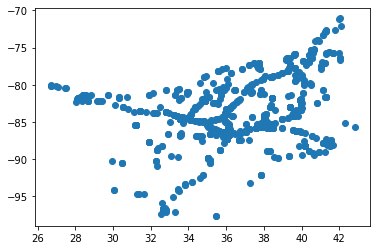

In [39]:
plt.scatter(derate['Latitude'], derate['Longitude'])

In [40]:
derate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195 entries, 45 to 1185275
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecordID               1195 non-null   int64  
 1   ESS_Id                 1195 non-null   int64  
 2   EventTimeStamp         1195 non-null   object 
 3   eventDescription       0 non-null      object 
 4   actionDescription      0 non-null      float64
 5   ecuSoftwareVersion     1005 non-null   object 
 6   ecuSerialNumber        975 non-null    object 
 7   ecuModel               997 non-null    object 
 8   ecuMake                997 non-null    object 
 9   ecuSource              1195 non-null   int64  
 10  spn                    1195 non-null   int64  
 11  fmi                    1195 non-null   int64  
 12  active                 1195 non-null   bool   
 13  activeTransitionCount  1195 non-null   int64  
 14  faultValue             0 non-null      float64
 15  

In [58]:
vehicle

,Truck Number,Year,Make,Serial
0,535,1996,PETERBILT,1XPCDR8XXVN431011
1,534,1996,PETERBILT,1XPCPR8X8VN431010
2,533,1996,PETERBILT,1XPCDR8X1VN431009
3,532,1996,PETERBILT,1XPCDR8XXVN431008
4,531,1996,PETERBILT,1XPCDR8X8VN431007
...,...,...,...,...
195,713,2004,VOLVO,4V4NC9TG84N355473
196,714,2004,VOLVO,4V4NC9TGX4N355474
197,715,2004,VOLVO,4V4NC9TG14N355475
198,716,2004,VOLVO,4V4NC9TG34N355476


In [35]:
pd.pivot_table(diag, columns= ['Name'], values = 'Value', index = 'FaultId', aggfunc= 'first').reset_index()

Name,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,0,14.21,False,66.48672,423178.7,100.4,11,0,96.74375,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1187331,1248455,100,14.5,True,64.6226,423937.9,185,51,37.12,211.4937,...,32,True,98.6,18431,False,NaN,65.01096,NaN,73.2,7.83
1187332,1248456,0,14.355,True,66.48672,465925.4,186.8,62,41.18,212.8438,...,NaN,True,91.4,17407,NaN,NaN,66.5741,NaN,100,6.96
1187333,1248457,1.6,14.4275,False,67.72946,28606.65625,181.4,0,27.26,221.7312,...,NaN,True,100.4,1023,False,NaN,11.84489,14.1,100,1.74


In [18]:
faults

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000
